# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:red">  Numerical exercises 7: Metropolis - NVT Ensemble</span>

$\textbf{Introduction}$

In this exercise we were given a code which simulates, with the Metropolis algorithm, the dynamics of an N particle system in NVT statistical ensemble using:
- a uniform transition probability function $T(\vec{y}\vert\vec{x})$ for the sampling of a new proposed position
- Boltzmann's energy distribution function $\rho=e^{-\beta E}/Z\,$ for the probability of accepting the proposed move $P=min(1\,,\, \rho\,(\vec{y})/\rho\,(\vec{x}))$

The code already computed istantaneous values and average values (with statistical uncertainties) of energy per particle and pressure in reduced units; we were asked to improve this code by:
- using $10^5$ istantaneous values in order to compute the correlation time of the three phases
- using the same data to study the estimation of statistical uncertainties as a function of the block length
- adding the sampling of the radial distribution function g(r)
- simulating the dynamics of solid, liquid and gas phases of Argon and Krypton

$\textbf{Autocorrelation function}$

Given an array of values x(t) the autocorrelation function of the array is given by:

$$ Ac(\tau) = \frac{\langle x(t+\tau)\,x(t) \rangle - \langle x(t+\tau) \rangle \, \langle x(t) \rangle}{\sigma_x^2}$$

In our simulation we want to apply the Central Limit Theorem which lets us use the data blocking technique for statistical uncertainties; unfortunately, the CLT hypotesis of independent variables is not respected.  
We avoid this problem by computing the autocorrelation function on $10^5$ istantaneous values of energy and pressure for each of the three phases (after an equilibration of the values and of the Metropolis acceptance rate); this will give us an estimation of the correlation time and thus on how long should be each block in our simulation in order to minimize the effect of the correlation between the istantaneous values.

The equilibration is obtained differently for gas and solid/liquid phases, because due to the characteristics of gas phase its acceptance rate never goes under $\sim$ 60%. I've included an *equilibration* variable in the input file which, if set to 1, forces the program to only equilibrate the value of $\delta$ printing it at the end of the run (in this phase one should also set *restart* = 0 and *SI_units* = 0, which are variables that will serve us later); actually in this phase one also obtains the equilibration for the istantaneous values if he uses nblocks $\sim 1000$ of $1$ step.  
We can now set $\delta$ in the input file as the value printed out on the screen (what it turns out is that $\delta_{solid} \sim 0.11$, $\delta_{liquid} \sim 0.2$ and $\delta_{gas} \sim 8$, so I suggest to start from about $0.05$, $0.1$ and $1$ respectively in the equilibration phase), *equilibration* = 0 (or any other value $\neq$ 1), *restart* = 1 (which forces the program to read the final configuration obtained in the equilibration as the initial configuration, in order to start from equilibrated values of energy and pressure) and the desired number of istantaneous values to compute the autocorrelation function (in the *nblocks* variable, keeping *nstep* = 1).

The following python script contains the definition of the autocorrelation function (and the exponential function we will use to fit it).

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

#exponential function for the fit
def exponential(x, x0):
    return np.exp(-x/x0)

#autocorrelation function
def autocorrelation(x, data):
    x_t = 0
    x_tplustau = 0
    x_t_tplustau = 0
    for k in range(0,(int)(len(data)-x)):
        x_t += data[k]
        x_tplustau += data[(int)(k+x)]
        x_t_tplustau += data[k]*data[(int)(k+x)]
    x_t = x_t/(len(data)-x)
    x_tplustau = x_tplustau/(len(data)-x)
    x_t_tplustau = x_t_tplustau/(len(data)-x)
    x1=0
    x2=0
    for k in range(0,len(data)):
        x1+=data[k]
        x2+=data[k]*data[k]
    variance = x2/len(data)-(x1/len(data))**2
    
    return (x_t_tplustau - x_t*x_tplustau)/variance

I've already equilibrated and simulated the required $10^5$ instantaneous values of energy and pressure for the three phases (and stored them in Solid, Liquid and Gas directories).  
The graphs below show the autocorrelation function $Ac(\tau)$ obtained for $\tau \in [2,500]$ on the previously obtained data.

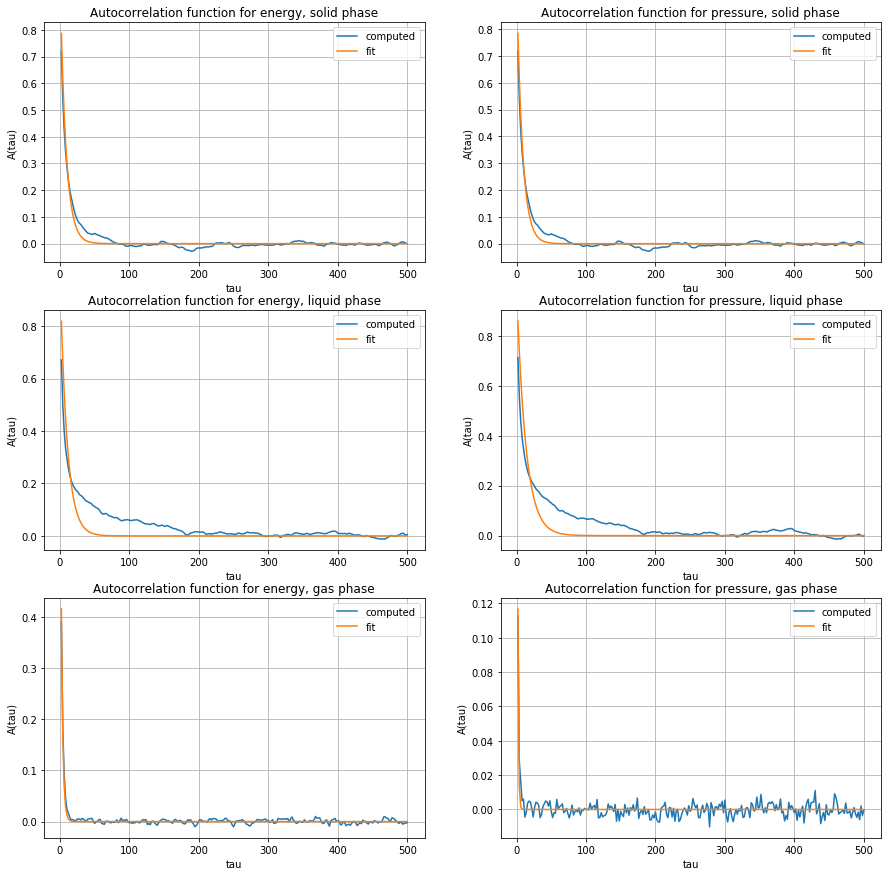

In [2]:
#Solid phase, energy
solid_energy = np.loadtxt("Solid/output_epot.txt", usecols=(1), unpack='true')
dim = 250
tau = np.zeros(dim)
ac = np.zeros(dim)
for k in range (0,dim):
    tau[k]=(k+1)*2
    ac[k] = autocorrelation(tau[k], solid_energy)
best_vals, covar = curve_fit(exponential, tau, ac, p0=1)  
plt.figure(figsize=(15, 15))
plt.subplot(3,2,1)
plt.plot(tau, ac, label='computed')
plt.plot(tau, exponential(tau, best_vals), label='fit')
plt.xlabel('tau')
plt.ylabel('A(tau)')
plt.title('Autocorrelation function for energy, solid phase')
plt.grid()
plt.legend()

#Solid phase, pressure
solid_pressure = np.loadtxt("Solid/output_pres.txt", usecols=(1), unpack='true')
for k in range (0,dim):
    ac[k] = autocorrelation(tau[k], solid_pressure)
best_vals, covar = curve_fit(exponential, tau, ac, p0=1)
plt.subplot(3,2,2)
plt.plot(tau, ac, label='computed')
plt.plot(tau, exponential(tau, best_vals), label='fit')
plt.xlabel('tau')
plt.ylabel('A(tau)')
plt.title('Autocorrelation function for pressure, solid phase')
plt.grid()
plt.legend()



#Liquid phase, energy
liquid_energy = np.loadtxt("Liquid/output_epot.txt", usecols=(1), unpack='true')
for k in range (0,dim):
    ac[k] = autocorrelation(tau[k], liquid_energy)
best_vals, covar = curve_fit(exponential, tau, ac, p0=1)
plt.subplot(3,2,3)
plt.plot(tau, ac, label='computed')
plt.plot(tau, exponential(tau, best_vals), label='fit')
plt.xlabel('tau')
plt.ylabel('A(tau)')
plt.title('Autocorrelation function for energy, liquid phase')
plt.grid()
plt.legend()

#Liquid phase, pressure
liquid_pressure = np.loadtxt("Liquid/output_pres.txt", usecols=(1), unpack='true')
for k in range (0,dim):
    ac[k] = autocorrelation(tau[k], liquid_pressure)
best_vals, covar = curve_fit(exponential, tau, ac, p0=1)
plt.subplot(3,2,4)
plt.plot(tau, ac, label='computed')
plt.plot(tau, exponential(tau, best_vals), label='fit')
plt.xlabel('tau')
plt.ylabel('A(tau)')
plt.title('Autocorrelation function for pressure, liquid phase')
plt.grid()
plt.legend()



#Gas phase, energy
gas_energy = np.loadtxt("Gas/output_epot.txt", usecols=(1), unpack='true')
for k in range (0,dim):
    ac[k] = autocorrelation(tau[k], gas_energy)
best_vals, covar = curve_fit(exponential, tau, ac, p0=1)
plt.subplot(3,2,5)
plt.plot(tau, ac, label='computed')
plt.plot(tau, exponential(tau, best_vals), label='fit')
plt.xlabel('tau')
plt.ylabel('A(tau)')
plt.title('Autocorrelation function for energy, gas phase')
plt.grid()
plt.legend()

#Gas phase, pressure
gas_pressure = np.loadtxt("Gas/output_pres.txt", usecols=(1), unpack='true')
for k in range (0,dim):
    ac[k] = autocorrelation(tau[k], gas_pressure)
best_vals, covar = curve_fit(exponential, tau, ac, p0=1)
plt.subplot(3,2,6)
plt.plot(tau, ac, label='computed')
plt.plot(tau, exponential(tau, best_vals), label='fit')
plt.xlabel('tau')
plt.ylabel('A(tau)')
plt.title('Autocorrelation function for pressure, gas phase')
plt.grid()
plt.legend()

plt.show()

We can see from the graphs that the value of $\tau$ for which the autocorrelation goes $\sim 0$ is:
- $\tau \sim 100\;$ for the solid phase
- $\tau \sim 300\;$ for the liquid phase
- $\tau \sim 10\;$ for the gas phase (hard to exactly estimate, but i's very low, and that's the point)

In order to be safe, in our simulations we should use blocks long at least $10\,\tau$ (actually I've used higher values, I'll say it later).

$\textbf{Statistical uncertainties}$

We can have another estimation on how long our blocks should be from the trend of the statistical uncertainty as a function of the block length: the following python script computes the statistical uncertainty with the data blocking technique for energy and pressure in the three phases (with block length from 10 to 5000), using the data previously used for autocorrelation functions.  
The results are shown in the graphs below.

In [19]:
M = 100000

size = 500
L=np.zeros(size)
N=np.zeros(size)
for k in range (0,size):
    L[k] = 10*(k+1)
    N[k] = (int)(M/L[k])


    
def error(vector, block_length, n_blocks):
    prog_blkaverage=0
    prog_squared_blkaverage=0
    for j in range (0,(int)(n_blocks)):
        prog_sum = 0
        for i in range ((int)(j*block_length),(int)((j+1)*block_length)):
            prog_sum += vector[i]
        blkaverage = prog_sum/(float)(block_length)
        squared_blkaverage = blkaverage*blkaverage
        prog_blkaverage += blkaverage
        prog_squared_blkaverage += squared_blkaverage
    average = 1.0/(float)(n_blocks) * prog_blkaverage
    squared_average = 1.0/(float)(n_blocks) * prog_squared_blkaverage
    return np.sqrt(1.0/(float)(n_blocks-1) * (squared_average - average*average))

solid_epot_error = np.zeros(size)
solid_pres_error = np.zeros(size)
liquid_epot_error = np.zeros(size)
liquid_pres_error = np.zeros(size)
gas_epot_error = np.zeros(size)
gas_pres_error = np.zeros(size)

for k in range (0, size):
    solid_epot_error[k] = error(solid_energy, L[k], N[k])
    solid_pres_error[k] = error(solid_pressure, L[k], N[k])
    liquid_epot_error[k] = error(liquid_energy, L[k], N[k])
    liquid_pres_error[k] = error(liquid_pressure, L[k], N[k])
    gas_epot_error[k] = error(gas_energy, L[k], N[k])
    gas_pres_error[k] = error(gas_pressure, L[k], N[k])

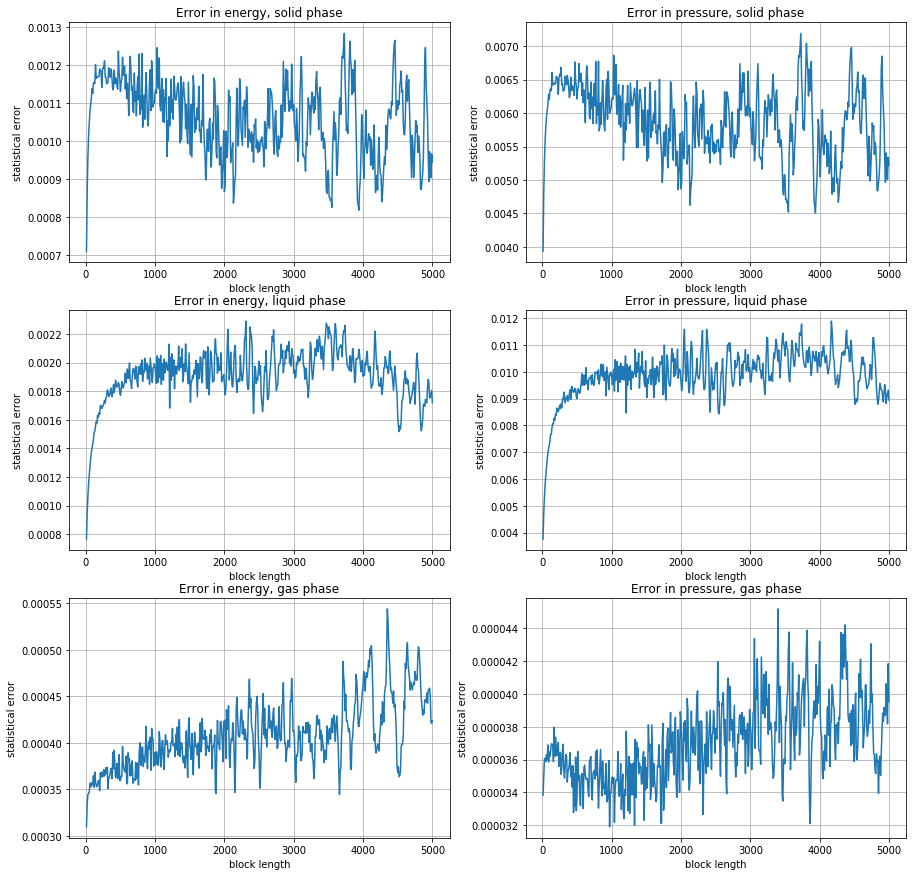

In [20]:
plt.figure(figsize=(15, 15))
plt.subplot(3,2,1)
plt.plot(L,solid_epot_error)
plt.xlabel('block length')
plt.ylabel('statistical error')
plt.title('Error in energy, solid phase')
plt.grid()

plt.subplot(3,2,2)
plt.plot(L,solid_pres_error)
plt.xlabel('block length')
plt.ylabel('statistical error')
plt.title('Error in pressure, solid phase')
plt.grid()

plt.subplot(3,2,3)
plt.plot(L,liquid_epot_error)
plt.xlabel('block length')
plt.ylabel('statistical error')
plt.title('Error in energy, liquid phase')
plt.grid()

plt.subplot(3,2,4)
plt.plot(L,liquid_pres_error)
plt.xlabel('block length')
plt.ylabel('statistical error')
plt.title('Error in pressure, liquid phase')
plt.grid()

plt.subplot(3,2,5)
plt.plot(L,gas_epot_error)
plt.xlabel('block length')
plt.ylabel('statistical error')
plt.title('Error in energy, gas phase')
plt.grid()

plt.subplot(3,2,6)
plt.plot(L,gas_pres_error)
plt.xlabel('block length')
plt.ylabel('statistical error')
plt.title('Error in pressure, gas phase')
plt.grid()

plt.show()

The graphs are in agreement with the previously obtained value of the correlation time (the data start to be not correlated when the function stops her trend, i.e. when it stops growing and starts to variate only for statistical fluctuations).  
N.B. in order to obtain equally spaced evaluations of the error I've cut off the data whenever the bolck length times the number of blocks exceeded M (actually I've computed the number of blocks as $(int)(10^5/L)$); by doing this I make an error of 5% at maximum, which is when the block length approaches 5000.

$\textbf{Simulations of Argon and Krypton - Energy and Pressure}$

From the information given by the autocorrelation functions and the statistical uncertainties trend I've chosen:
- 20 blocks of 5000 steps for solid phase
- 10 blocks of 10000 steps for liquid phase
- 50 blocks of 2000 steps for gas phase

The actual simulation of physical systems is made for Argon and Krypton, for each of the three phases (solid, liquid and gas). All the calculations in the code are made with reduced units, so there's no difference between the two systems, and the conversion in SI units is included only in the final printing of the average values (and activated in the input file by *SI_units* variable, set to 1) by:
- energy(J) = energy(red.un.) x $\epsilon$
- pressure(Pa) = pressure(red.un.) x $\displaystyle\frac{\epsilon}{\sigma^3}$

I've already made all simulations and stored the output files in directories Solid, Liquid and Gas; the graphs below show the obtained results.

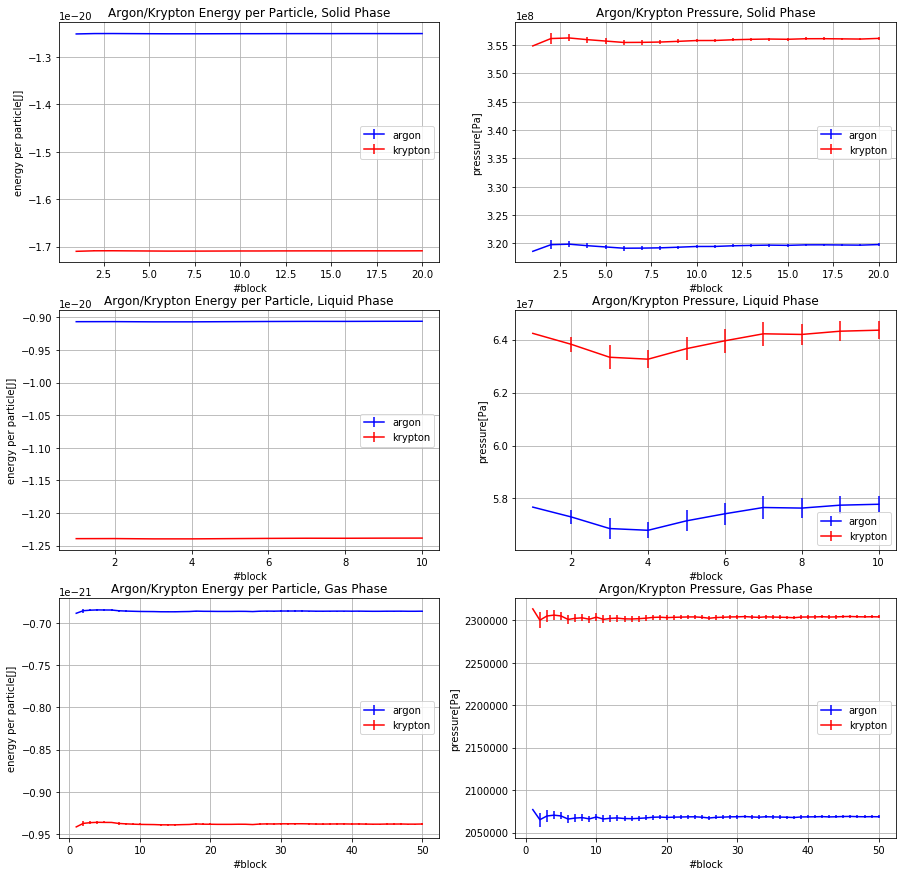

In [2]:
plt.figure(figsize=(15,15))

plt.subplot(3,2,1)
x, f, error = np.loadtxt("Solid/argon_output_epot.txt", usecols=(0,1,2), unpack='true')
plt.errorbar(x,f,yerr=error, color='b', label='argon')
x, f, error = np.loadtxt("Solid/krypton_output_epot.txt", usecols=(0,1,2), unpack='true')
plt.errorbar(x,f,yerr=error, color='r', label='krypton')
plt.xlabel('#block')
plt.ylabel('energy per particle[J]')
plt.title('Argon/Krypton Energy per Particle, Solid Phase')
plt.legend()
plt.grid()

plt.subplot(3,2,2)
x, f, error = np.loadtxt("Solid/argon_output_pres.txt", usecols=(0,1,2), unpack='true')
plt.errorbar(x,f,yerr=error, color='b', label='argon')
x, f, error = np.loadtxt("Solid/krypton_output_pres.txt", usecols=(0,1,2), unpack='true')
plt.errorbar(x,f,yerr=error, color='r', label='krypton')
plt.xlabel('#block')
plt.ylabel('pressure[Pa]')
plt.title('Argon/Krypton Pressure, Solid Phase')
plt.legend()
plt.grid()

plt.subplot(3,2,3)
x, f, error = np.loadtxt("Liquid/argon_output_epot.txt", usecols=(0,1,2), unpack='true')
plt.errorbar(x,f,yerr=error, color='b', label='argon')
x, f, error = np.loadtxt("Liquid/krypton_output_epot.txt", usecols=(0,1,2), unpack='true')
plt.errorbar(x,f,yerr=error, color='r', label='krypton')
plt.xlabel('#block')
plt.ylabel('energy per particle[J]')
plt.title('Argon/Krypton Energy per Particle, Liquid Phase')
plt.legend()
plt.grid()

plt.subplot(3,2,4)
x, f, error = np.loadtxt("Liquid/argon_output_pres.txt", usecols=(0,1,2), unpack='true')
plt.errorbar(x,f,yerr=error, color='b', label='argon')
x, f, error = np.loadtxt("Liquid/krypton_output_pres.txt", usecols=(0,1,2), unpack='true')
plt.errorbar(x,f,yerr=error, color='r', label='krypton')
plt.xlabel('#block')
plt.ylabel('pressure[Pa]')
plt.title('Argon/Krypton Pressure, Liquid Phase')
plt.legend()
plt.grid()

plt.subplot(3,2,5)
x, f, error = np.loadtxt("Gas/argon_output_epot.txt", usecols=(0,1,2), unpack='true')
plt.errorbar(x,f,yerr=error, color='b', label='argon')
x, f, error = np.loadtxt("Gas/krypton_output_epot.txt", usecols=(0,1,2), unpack='true')
plt.errorbar(x,f,yerr=error, color='r', label='krypton')
plt.xlabel('#block')
plt.ylabel('energy per particle[J]')
plt.title('Argon/Krypton Energy per Particle, Gas Phase')
plt.legend()
plt.grid()

plt.subplot(3,2,6)
x, f, error = np.loadtxt("Gas/argon_output_pres.txt", usecols=(0,1,2), unpack='true')
plt.errorbar(x,f,yerr=error, color='b', label='argon')
x, f, error = np.loadtxt("Gas/krypton_output_pres.txt", usecols=(0,1,2), unpack='true')
plt.errorbar(x,f,yerr=error, color='r', label='krypton')
plt.xlabel('#block')
plt.ylabel('pressure[Pa]')
plt.title('Argon/Krypton Pressure, Gas Phase')
plt.legend()
plt.grid()

plt.show()

$\textbf{Simulations of Argon and Krypton - Radial Distribution Function g(r)}$

The radial distribution function gives us some information on the structure of monoatomic fluids, in particuar it indicates the probability of finding a pair of atoms at a distance r, relative to the probability expected for a completely random distribution at the same density (i.e an ideal gas).  
It can be shown that the radial distribution function has this form:

$$ g(r) = \frac{1}{\rho N \Delta V(r)}\big\langle\sum_{j=1}^N\sum_{i>j}\delta[|\vec{r}| - |(\vec{r}_i - \vec{r}_j)|]\big\rangle$$

where $\Delta V(r) = \frac{4}{3}\pi\,[(r+dr)^3 - r^3]$

I've included the calculation of g(r) in the code by filling an histogram (between r=0 and r=Lbox/2) increasing a bin by two (for every r that I find, I have two particles at distance r) whenever I find two particles at distance between r and r+dr; at the end of the simulation I normalize the histogram with the quantity $\rho N \Delta V(r)$.

The simulation of g(r) is made for Argon and Krypton in each of the three phases; the results obtained (already computed and stored in the usual Solid, Liquid and Gas directories) are shown in the graphs below.

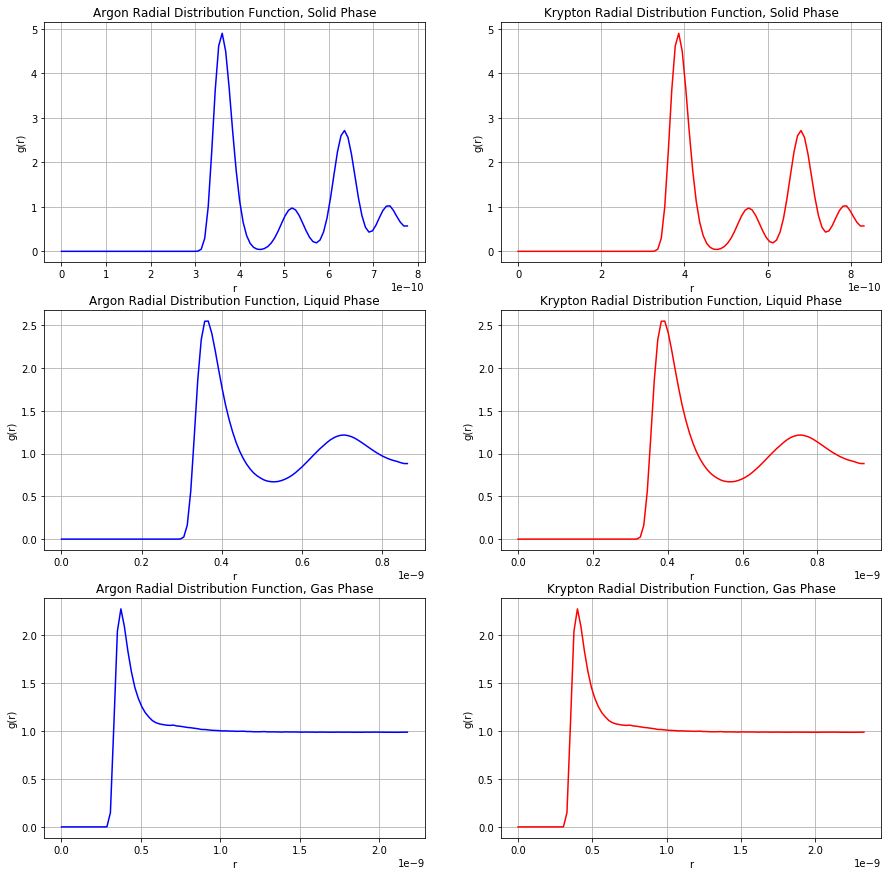

In [3]:
plt.figure(figsize=(15,15))

plt.subplot(3,2,1)
r, gofr = np.loadtxt("Solid/argon_output_gofr.txt",usecols=(0,1), unpack='true')
plt.plot(r, gofr,color='b')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Argon Radial Distribution Function, Solid Phase')
plt.grid()

plt.subplot(3,2,2)
r, gofr = np.loadtxt("Solid/krypton_output_gofr.txt",usecols=(0,1), unpack='true')
plt.plot(r, gofr, color='r')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Krypton Radial Distribution Function, Solid Phase')
plt.grid()

plt.subplot(3,2,3)
r, gofr = np.loadtxt("Liquid/argon_output_gofr.txt",usecols=(0,1), unpack='true')
plt.plot(r, gofr,color='b')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Argon Radial Distribution Function, Liquid Phase')
plt.grid()

plt.subplot(3,2,4)
r, gofr = np.loadtxt("Liquid/krypton_output_gofr.txt",usecols=(0,1), unpack='true')
plt.plot(r, gofr, color='r')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Krypton Radial Distribution Function, Liquid Phase')
plt.grid()

plt.subplot(3,2,5)
r, gofr = np.loadtxt("Gas/argon_output_gofr.txt",usecols=(0,1), unpack='true')
plt.plot(r, gofr,color='b')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Argon Radial Distribution Function, Gas Phase')
plt.grid()

plt.subplot(3,2,6)
r, gofr = np.loadtxt("Gas/krypton_output_gofr.txt",usecols=(0,1), unpack='true')
plt.plot(r, gofr, color='r')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Krypton Radial Distribution Function, Gas Phase')
plt.grid()

plt.show()

$\textbf{Simulations of Argon and Krypton - NVE/NVT comparisons}$

I've included the calculation of g(r) in the NVE Molecular Dynamics code; the graphs below show the comparisons beween the g(r) functions between NVE and NVT for both Argon and Krypton in the three phases.

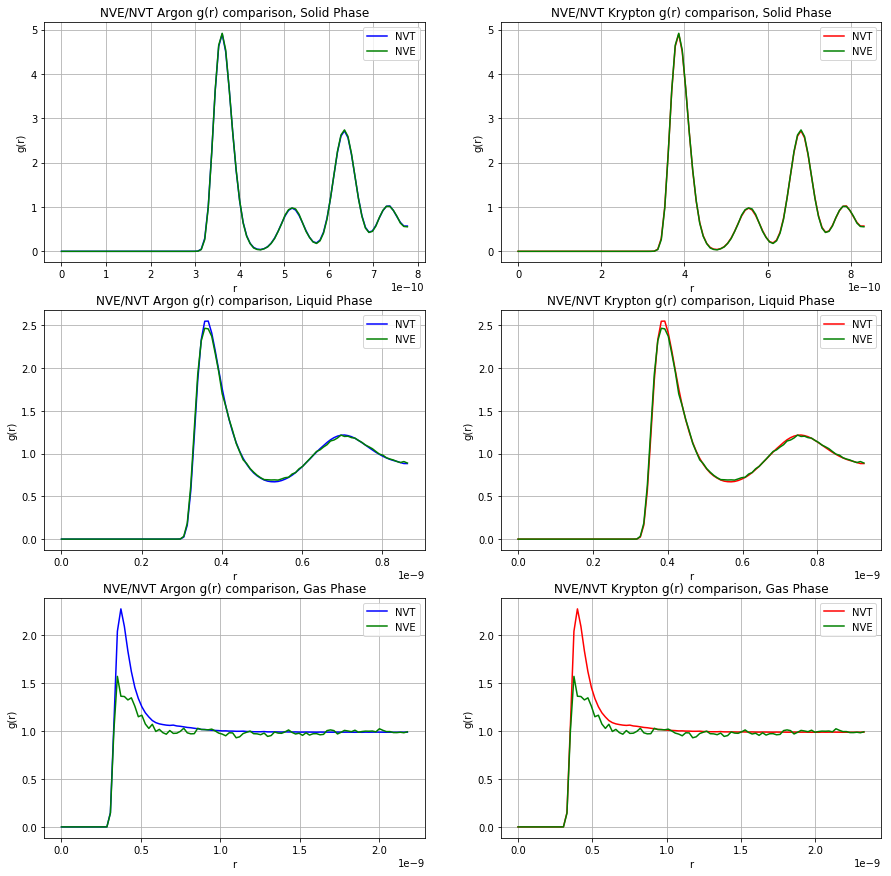

In [7]:
plt.figure(figsize=(15,15))

plt.subplot(3,2,1)
r, gofr = np.loadtxt("Solid/argon_output_gofr.txt",usecols=(0,1), unpack='true')
plt.plot(r, gofr,color='b', label='NVT')
r, gofr = np.loadtxt("Solid/NVE_argon_gofr.txt",usecols=(0,1), unpack='true')
plt.plot(r, gofr,color='g', label='NVE')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('NVE/NVT Argon g(r) comparison, Solid Phase')
plt.grid()
plt.legend()

plt.subplot(3,2,2)
r, gofr = np.loadtxt("Solid/krypton_output_gofr.txt",usecols=(0,1), unpack='true')
plt.plot(r, gofr,color='r', label='NVT')
r, gofr = np.loadtxt("Solid/NVE_krypton_gofr.txt",usecols=(0,1), unpack='true')
plt.plot(r, gofr,color='g', label='NVE')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('NVE/NVT Krypton g(r) comparison, Solid Phase')
plt.grid()
plt.legend()

plt.subplot(3,2,3)
r, gofr = np.loadtxt("Liquid/argon_output_gofr.txt",usecols=(0,1), unpack='true')
plt.plot(r, gofr,color='b', label='NVT')
r, gofr = np.loadtxt("Liquid/NVE_argon_gofr.txt",usecols=(0,1), unpack='true')
plt.plot(r, gofr,color='g', label='NVE')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('NVE/NVT Argon g(r) comparison, Liquid Phase')
plt.grid()
plt.legend()

plt.subplot(3,2,4)
r, gofr = np.loadtxt("Liquid/krypton_output_gofr.txt",usecols=(0,1), unpack='true')
plt.plot(r, gofr,color='r', label='NVT')
r, gofr = np.loadtxt("Liquid/NVE_krypton_gofr.txt",usecols=(0,1), unpack='true')
plt.plot(r, gofr,color='g', label='NVE')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('NVE/NVT Krypton g(r) comparison, Liquid Phase')
plt.grid()
plt.legend()

plt.subplot(3,2,5)
r, gofr = np.loadtxt("Gas/argon_output_gofr.txt",usecols=(0,1), unpack='true')
plt.plot(r, gofr,color='b', label='NVT')
r, gofr = np.loadtxt("Gas/NVE_argon_gofr.txt",usecols=(0,1), unpack='true')
plt.plot(r, gofr,color='g', label='NVE')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('NVE/NVT Argon g(r) comparison, Gas Phase')
plt.grid()
plt.legend()

plt.subplot(3,2,6)
r, gofr = np.loadtxt("Gas/krypton_output_gofr.txt",usecols=(0,1), unpack='true')
plt.plot(r, gofr,color='r', label='NVT')
r, gofr = np.loadtxt("Gas/NVE_krypton_gofr.txt",usecols=(0,1), unpack='true')
plt.plot(r, gofr,color='g', label='NVE')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('NVE/NVT Krypton g(r) comparison, Gas Phase')
plt.grid()
plt.legend()

plt.show()